# Replay demonstration

Running smln...
Schedule: {'TRG_START_T': 1, 'SMLN_DUR': 2}
Smln complete.


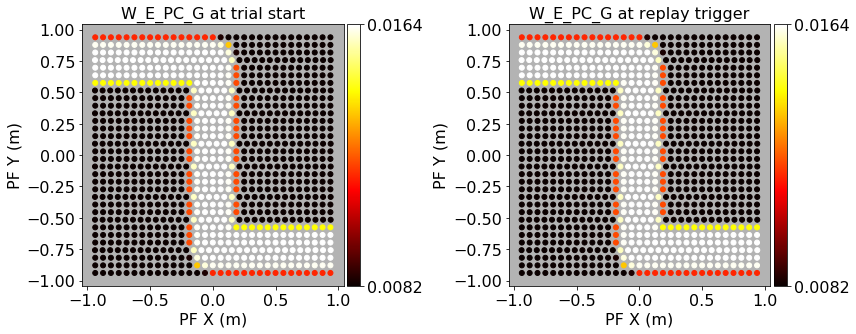

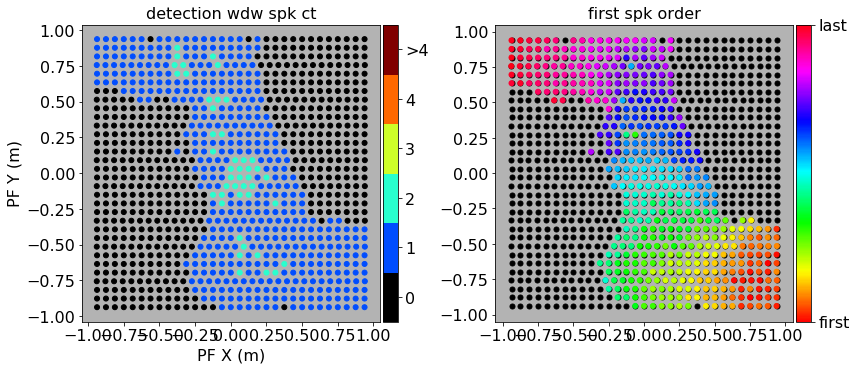

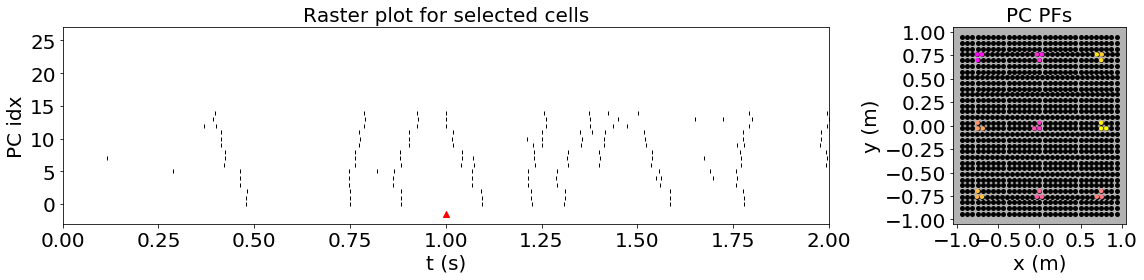

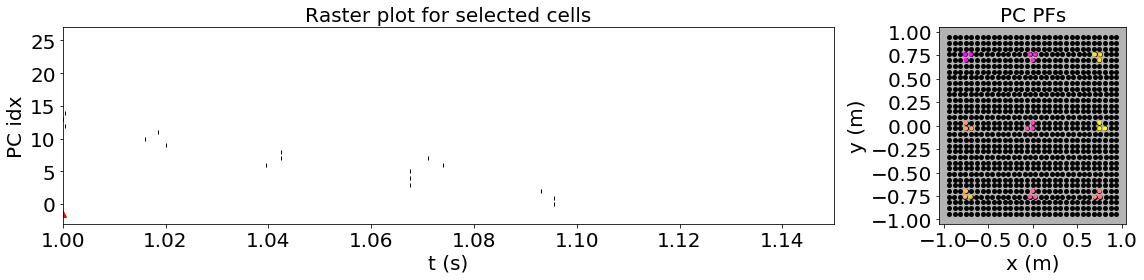

In [2]:
%reset -f
%matplotlib inline
import pdb
from replay import plot, smln

p = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    'E_AHP_PC': -0.07, 'T_AHP_PC': 0.05, 'W_AHP_PC': 0.0,
    
    # Exc. PC architecture
    'N_PC': 1000,
    'Z_PC_PC': 1.19, 'L_PC_PC': 0.084,
    'W_E_PC_PC': 0.024, 'S_E_PC_PC': 0,
    
    # "Place-tuned" PC inputs
    'W_E_PC_PL': 0.02, 'S_E_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.009, 'E_L_INH': -0.058, 'V_TH_INH': -0.036, 'V_R_INH': -0.058, 'T_R_INH': 0.002,  # unused (presently)
    
    # Inh. architecture
    'N_INH': 100,
    'Z_S_PC_INH': 1,  'L_S_PC_INH': 0.1,  # unused (presently)
    'Z_C_PC_INH': 1, 'L_C_PC_INH': 0.1,  # unused (presently)
    'W_E_INH_PC': 0., 'S_E_INH_PC': 0,   # unused (presently)
    
    'Z_INH_PC': 0., 'L_INH_PC': 0.1,  # unused (presently)
    'W_I_PC_INH': 0., 'S_I_PC_INH': 0.,  # unused (presently)
    
    # gating inputs
    'W_E_PC_G': 0.008216, 'S_E_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.005, 
    
    # Gating input firing rates for traj and replay epochs
    'FR_RPL_PC_G': 127, 
    
    # trigger 
    'A_TR': 0.008, 'R_TR': 0.4, 'D_T_TR': 0.003,
    
    # potentiation
    'W_G_MAX': 2,
}

s_params = {
    "RNG_SEED": 2,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    #'TRJ': [(-1, .75), (.75, .75), (.75, -.75)],
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)], 
    
    "schedule": {"SMLN_DUR": 2, "TRG_START_T": 1},
    
    "metrics": {
        "WDW": 0.1, "PITCH": 10, "RADIUS": 0.2, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }}

print('Running smln...')
rslt = smln.run(p, s_params)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, (1, 1.15));

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch='replay');

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch=(1, 1.15));

# Reference

Running smln...
Schedule: {'SMLN_DUR': 2, 'TRG_START_T': 1}
Smln complete.


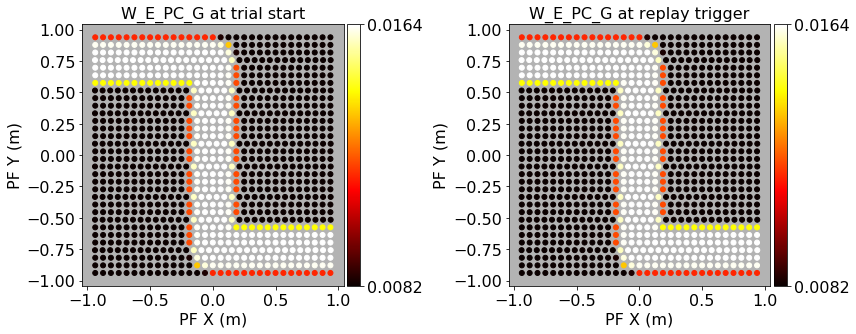

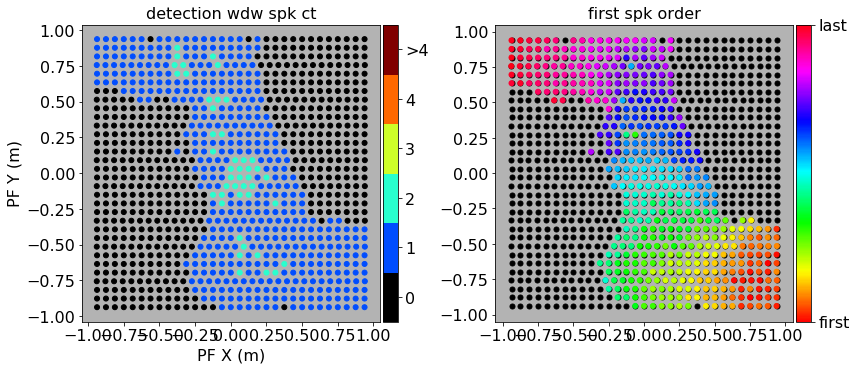

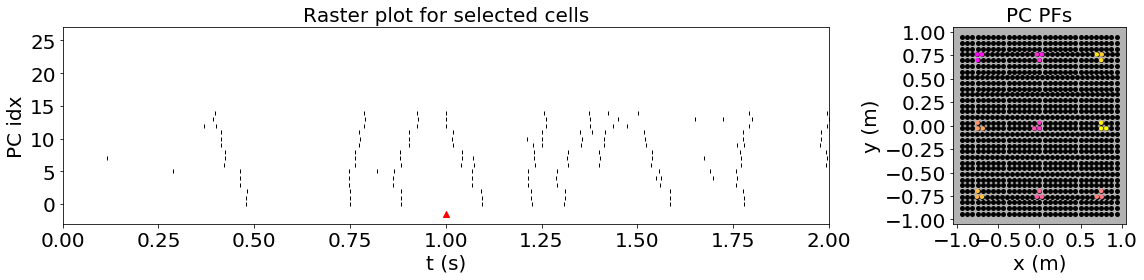

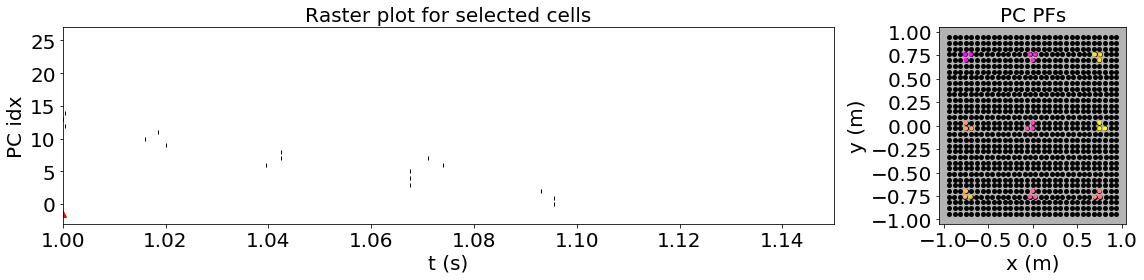

In [1]:
%reset -f
%matplotlib inline
import pdb
from replay import plot, smln

p = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    'E_AHP_PC': -0.07, 'T_AHP_PC': 0.05, 'W_AHP_PC': 0.0,
    
    # Exc. PC architecture
    'N_PC': 1000,
    'Z_PC_PC': 1.19, 'L_PC_PC': 0.084,
    'W_E_PC_PC': 0.024, 'S_E_PC_PC': 0,
    
    # "Place-tuned" PC inputs
    'W_E_PC_PL': 0.02, 'S_E_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.009, 'E_L_INH': -0.058, 'V_TH_INH': -0.036, 'V_R_INH': -0.058, 'T_R_INH': 0.002,  # unused (presently)
    
    # Inh. architecture
    'N_INH': 100,
    'Z_S_PC_INH': 1,  'L_S_PC_INH': 0.1,  # unused (presently)
    'Z_C_PC_INH': 1, 'L_C_PC_INH': 0.1,  # unused (presently)
    'W_E_INH_PC': 0., 'S_E_INH_PC': 0,   # unused (presently)
    
    'Z_INH_PC': 0., 'L_INH_PC': 0.1,  # unused (presently)
    'W_I_PC_INH': 0., 'S_I_PC_INH': 0.,  # unused (presently)
    
    # gating inputs
    'W_E_PC_G': 0.008216, 'S_E_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.005, 
    
    # Gating input firing rates for traj and replay epochs
    'FR_TRJ_PC_G': 0, 'FR_RPL_PC_G': 127, 
    
    # trigger 
    'A_TR': 0.008, 'R_TR': 0.4, 'D_T_TR': 0.003, 
    
    # potentiation
    'W_G_MAX': 2,
}

s_params = {
    "RNG_SEED": 2,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    #'TRJ': [(-1, .75), (.75, .75), (.75, -.75)],
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)], 
    
    "schedule": {"SMLN_DUR": 2, "TRG_START_T": 1},
    
    "metrics": {
        "WDW": 0.1, "PITCH": 10, "RADIUS": 0.2, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }}

print('Running smln...')
rslt = smln.run(p, s_params)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, (1, 1.15));

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch='replay');

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch=(1, 1.15));